# ! This optimisation approach is currently not maintained !

---


# Optimisation

This tutorial introduces the optimisation routine in TOAD.


In [1]:
# Prerequisites
from toad import TOAD
from sklearn.cluster import HDBSCAN  # type: ignore
from toad.shifts import ASDETECT
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# start by initiating TOAD
td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.coarsen(x=3, y=3, GMST=3, boundary="trim").reduce(np.mean)
td.data = td.data.drop_vars(td.cluster_vars)

## Basic optimisation

with `td.optimiste(var)` you can run a basic optimisation which optimises three paramters for the clustering process, namely min_cluster_size, shift_treshold and time_scale_param. The default clustering parameters to optimize are defined in `default_cluster_param_ranges` within `optimisation.__init__.py`.


In [3]:
td.optimise(var="thk")

  0%|          | 0/50 [00:00<?, ?it/s]

INFO: Applying detector ASDETECT to thk
INFO: thk_dts_cluster: Identified 7 CLUSTERS in 1,083 pts; Left behind 25.0% as noise (271 pts).
INFO: thk_dts_cluster: Identified 11 CLUSTERS in 1,342 pts; Left behind 23.2% as noise (311 pts).
INFO: thk_dts_cluster: Identified 8 CLUSTERS in 985 pts; Left behind 23.4% as noise (230 pts).
INFO: thk_dts_cluster: Identified 11 CLUSTERS in 1,242 pts; Left behind 21.6% as noise (268 pts).
INFO: thk_dts_cluster: Identified 5 CLUSTERS in 1,461 pts; Left behind 15.7% as noise (230 pts).
INFO: thk_dts_cluster: Identified 6 CLUSTERS in 1,033 pts; Left behind 26.2% as noise (271 pts).
INFO: thk_dts_cluster: Identified 12 CLUSTERS in 881 pts; Left behind 17.9% as noise (158 pts).
INFO: thk_dts_cluster: Identified 4 CLUSTERS in 1,461 pts; Left behind 17.0% as noise (248 pts).
INFO: thk_dts_cluster: Identified 2 CLUSTERS in 1,461 pts; Left behind 19.0% as noise (278 pts).
INFO: thk_dts_cluster: Identified 3 CLUSTERS in 1,461 pts; Left behind 14.9% as noise (2

Completed 50 trials in 10.61 seconds
Best trial: 41 with score 1.1505
Best params: {'min_cluster_size': 20, 'shift_threshold': 0.932051616755389, 'time_scale_factor': 1.0491973037888027}
Identified 8 clusters


Once the optimisation finished, the best solution is saved in the TOAD instance and we can plot the results:


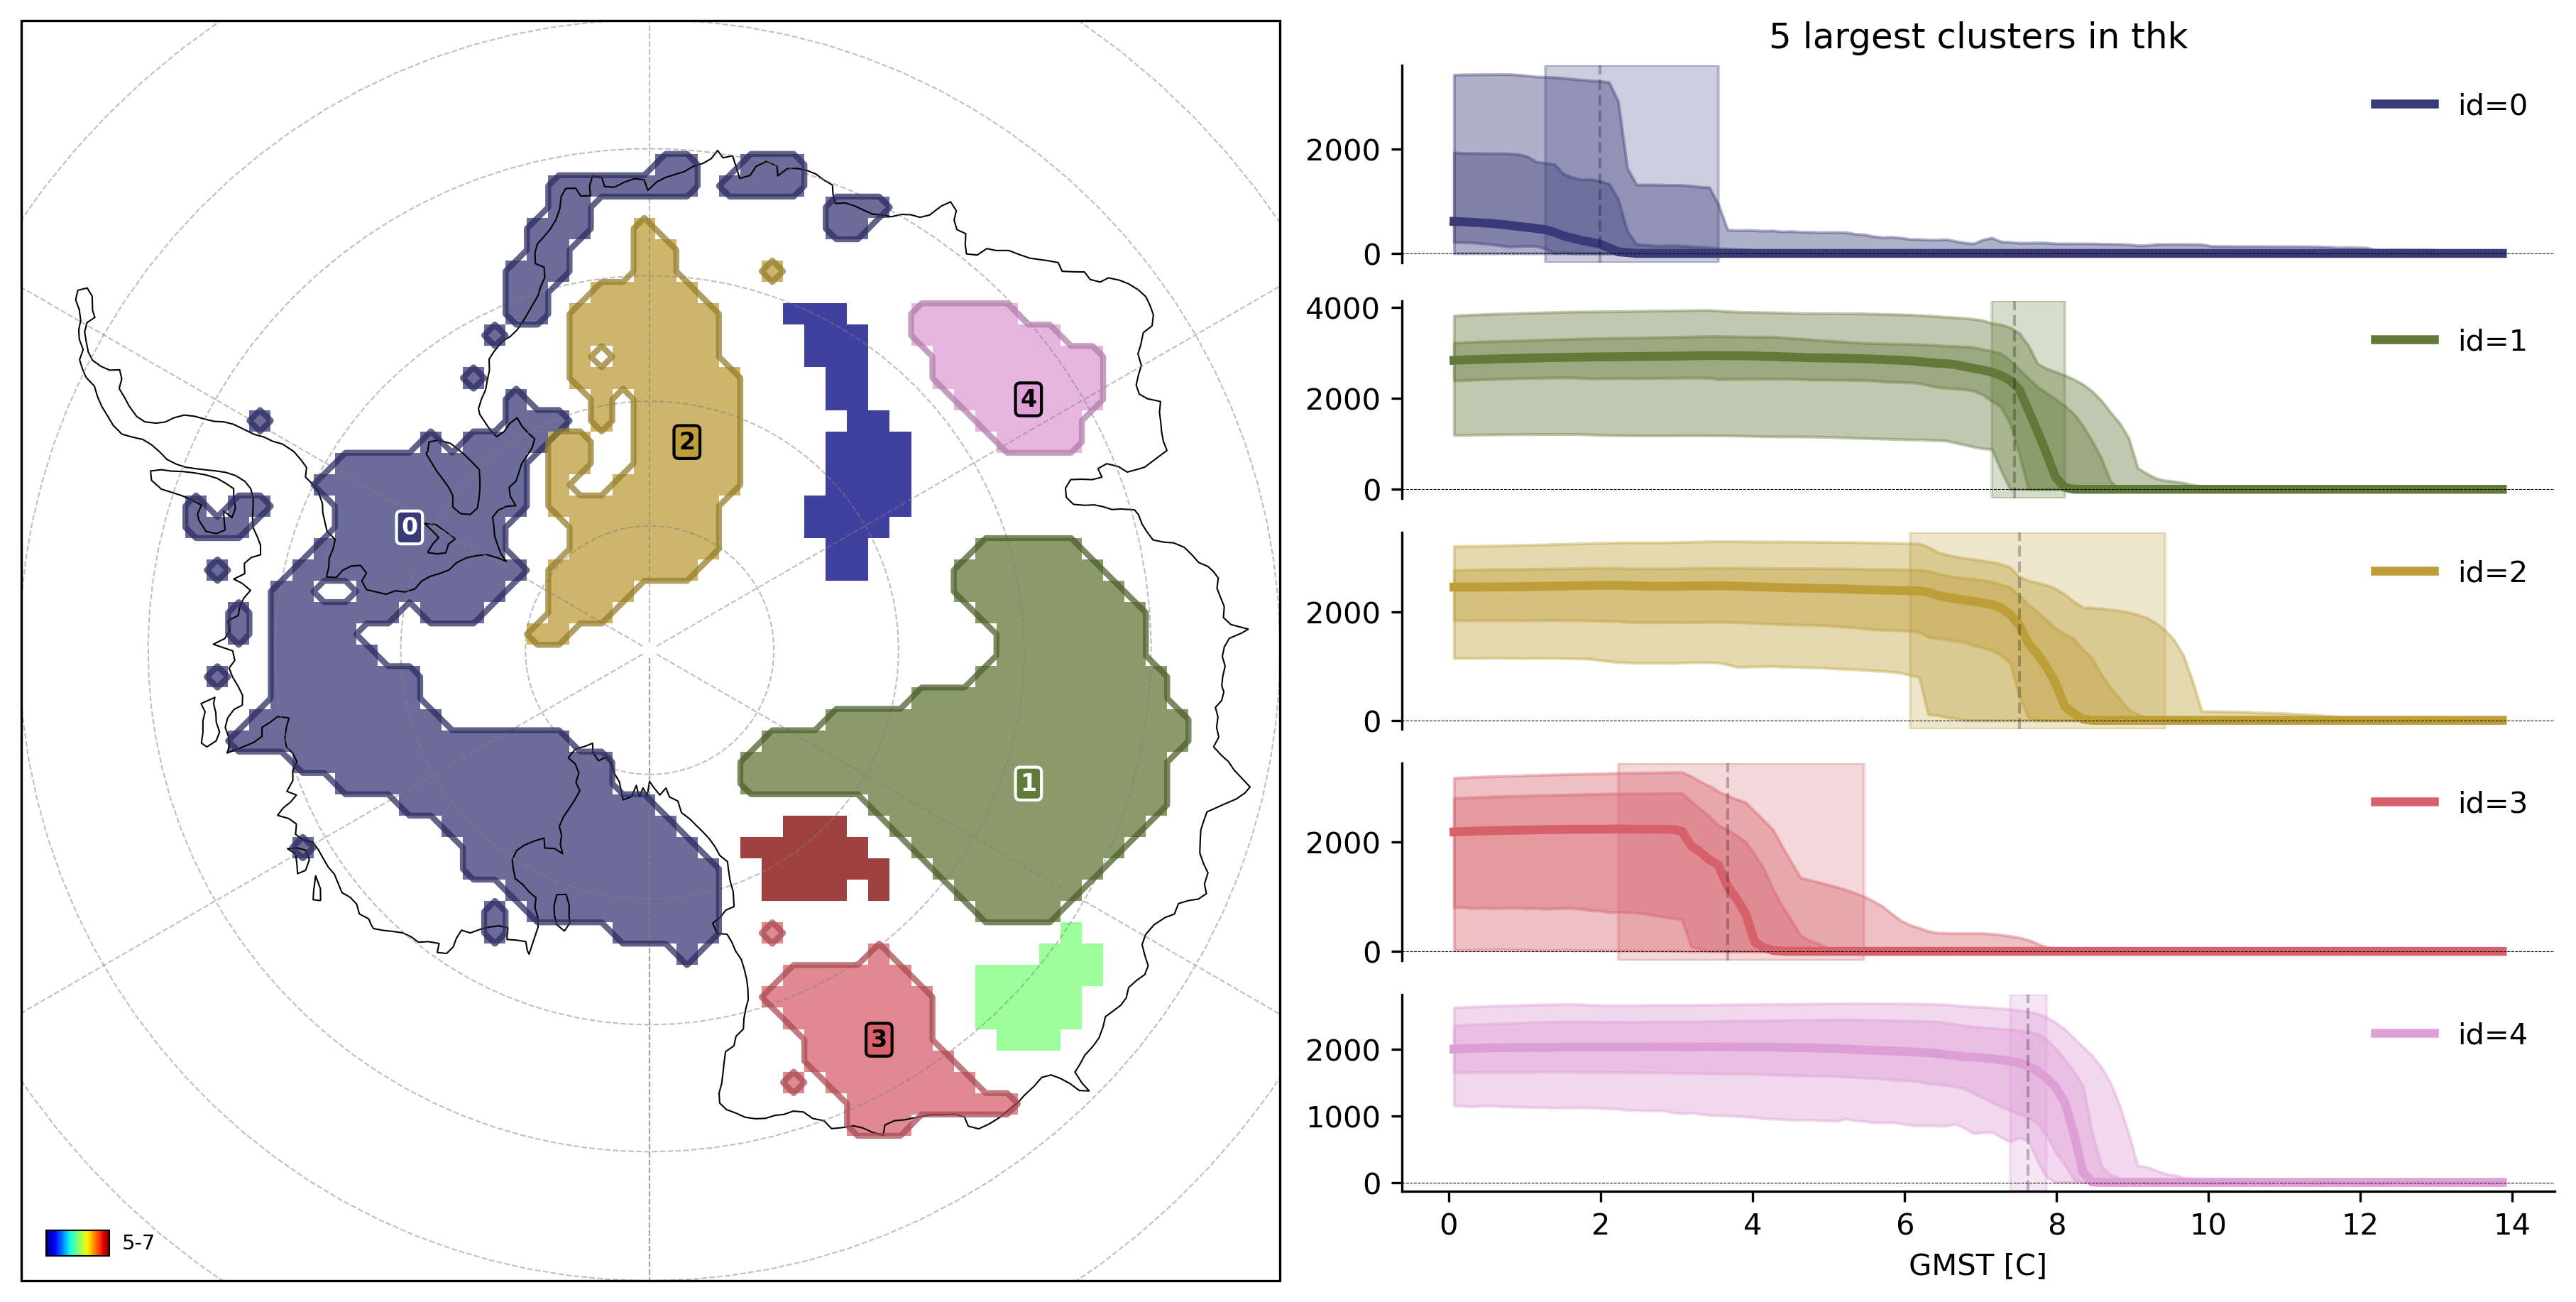

In [4]:
td.plotter().cluster_overview("thk", projection="south_pole");

## Defining param ranges and methods


The `optimise()` function provides fine-grained control over the optimization process:

- Choose which shift detection and clustering methods to use
- Customize parameter ranges for both methods:
  - Set ranges to explore (e.g. min_cluster_size=(8, 25))
  - Fix parameters to specific values (e.g. shift_threshold=0.9)
- Select an objective function from several built-in options (see docstring).
- Configure other optimization settings like number of trials

The example below demonstrates these capabilities.


In [5]:
td.optimise(
    shifts_method=ASDETECT,
    cluster_method=HDBSCAN,
    shifts_param_ranges={
        "lmax": (10, 30),
    },
    cluster_param_ranges={
        "min_cluster_size": (8, 25),
        "time_scale_factor": (0.5, 1.5),
        "shift_threshold": 0.9,  # or set a fixed value
    },
    objective="mean_spatial_autocorrelation",
    var="thk",
    n_trials=25,
)

  0%|          | 0/25 [00:00<?, ?it/s]

Completed 25 trials in 91.79 seconds
Best trial: 10 with score 0.8749
Best params: {'lmax': 30, 'min_cluster_size': 25, 'time_scale_factor': 1.1303412535995998}
Identified 22 clusters


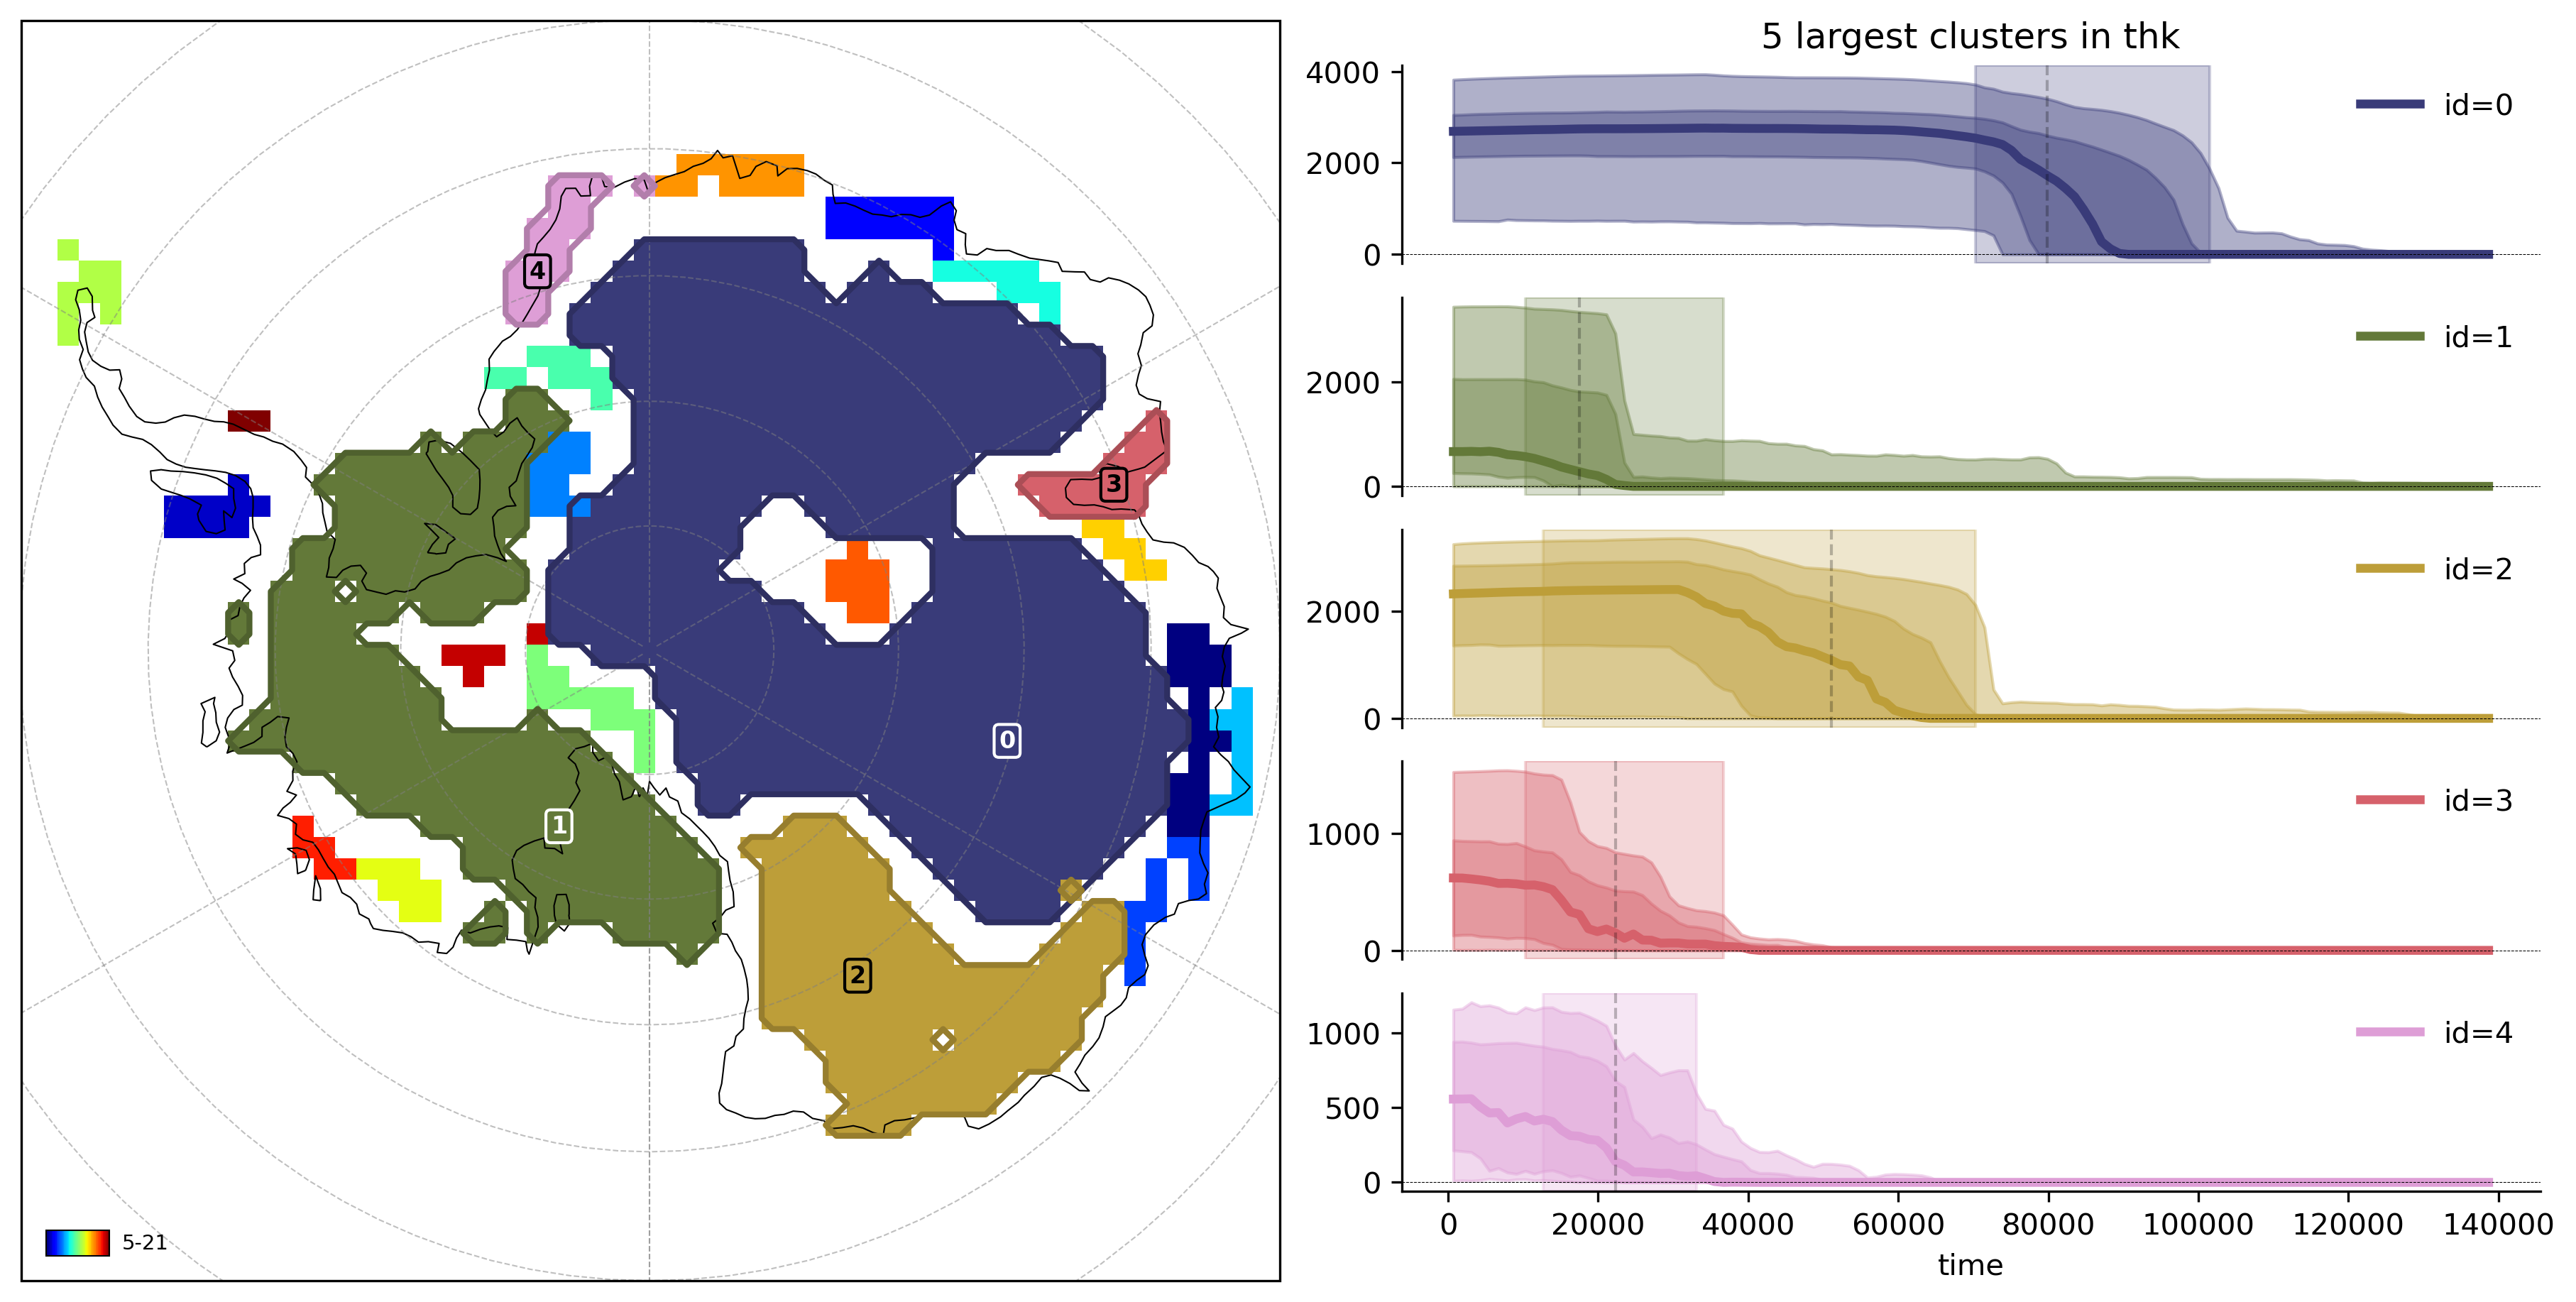

In [6]:
td.plotter().cluster_overview("thk", projection="south_pole");

## Defining your own optimisation function

You can also define your own optimisation cost function:


In [7]:
# Define objective function
def custom_objective_func(td, var) -> float:
    """In here you have access to the TOAD object after each computation and the variable name"""

    # Example of how one could compute a score using the cluster_stats object
    cluster_ids = td.get_cluster_ids(var)
    score1 = td.cluster_stats(var).general.aggregate_cluster_scores(
        cluster_ids=cluster_ids[:2],
        score_method="score_spatial_autocorrelation",
        aggregation="median",
    )

    # must return a float
    return float(score1)


# Run optimisation
td.optimise(
    shifts_method=ASDETECT,
    cluster_method=HDBSCAN,
    cluster_param_ranges={
        "min_cluster_size": (8, 25),
    },
    objective=custom_objective_func,  # pass the function to the optimisation routine
    direction="maximize",  # higher is better so set direction to "maximize"
    var="thk",
    n_trials=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Completed 10 trials in 17.84 seconds
Best trial: 7 with score 0.8076
Best params: {'min_cluster_size': 12}
Identified 24 clusters


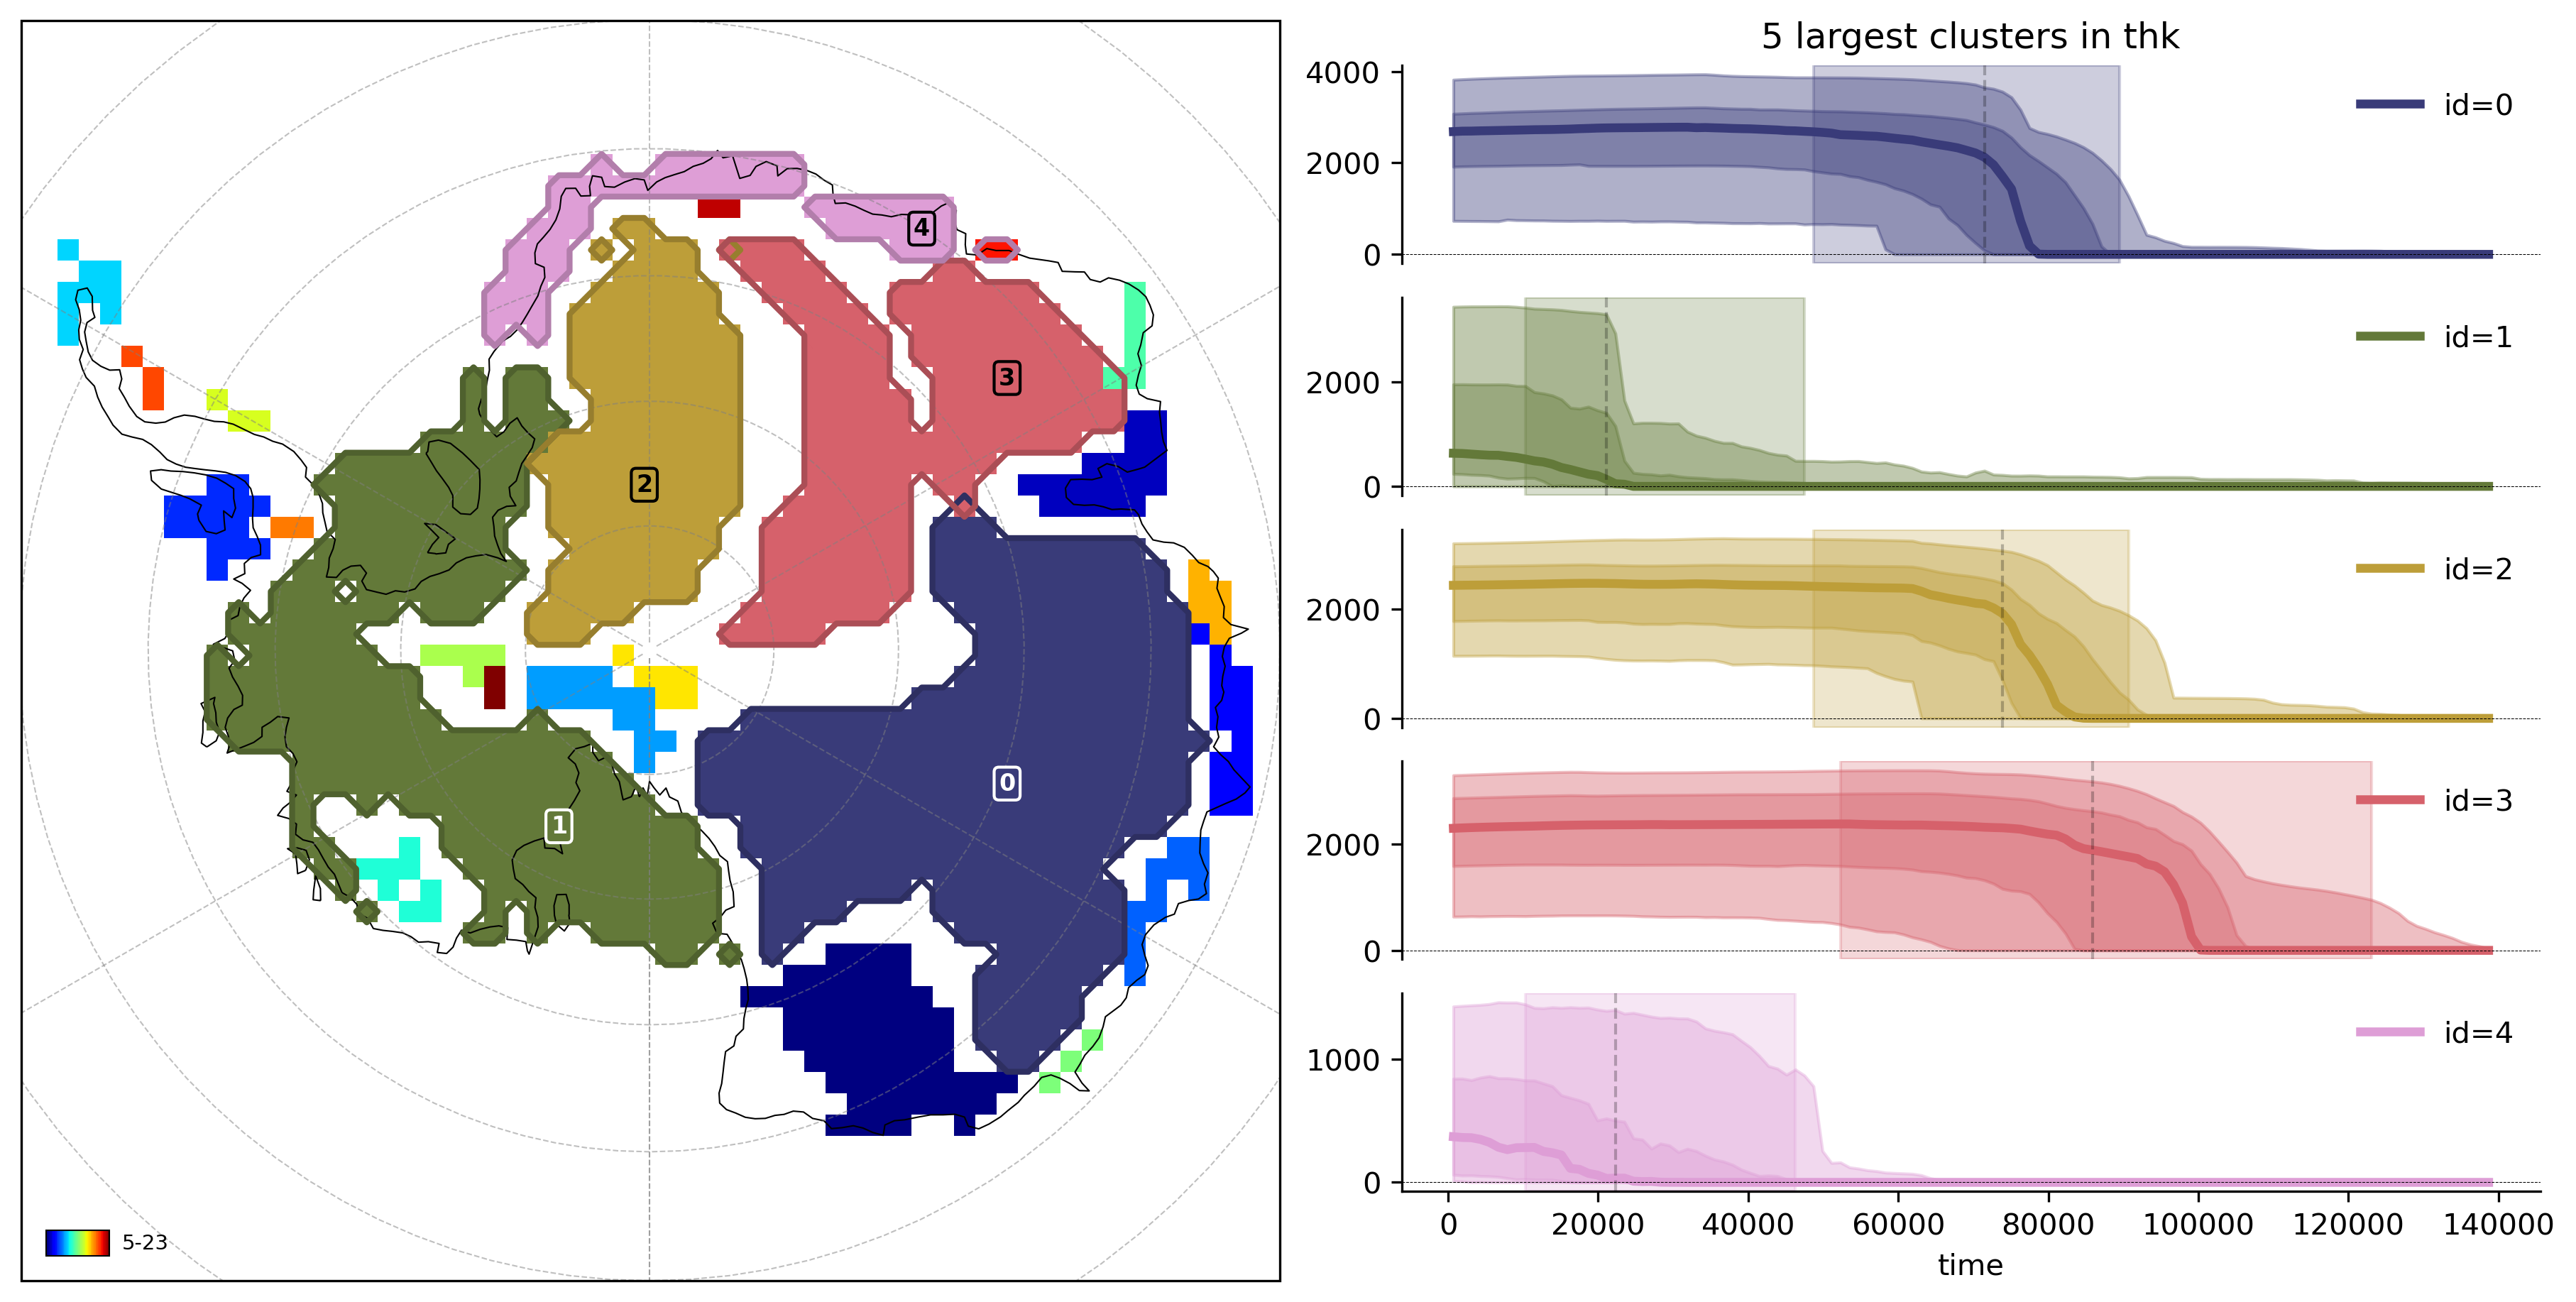

In [8]:
td.plotter().cluster_overview("thk", projection="south_pole");